<a href="https://colab.research.google.com/github/Rishi-128/ml4sci-contrastive-anomaly-dqm/blob/main/03_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection using a Contrastive Pretrained Encoder

This notebook demonstrates anomaly detection in detector data quality monitoring
using a self-supervised contrastively pretrained encoder. The encoder is frozen
and a lightweight decoder is trained on normal detector data. Anomalies are
identified using reconstruction error.


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import os

MODEL_DIR = "/content/drive/MyDrive/ml4sci_models"
os.listdir(MODEL_DIR)


['contrastive_encoder.pth']

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
class ContrastiveEncoder(nn.Module):
    def __init__(self, input_dim=10, latent_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, x):
        z = self.net(x)
        return nn.functional.normalize(z, dim=1)

encoder = ContrastiveEncoder(input_dim=10, latent_dim=32).to(device)
encoder.load_state_dict(
    torch.load(f"{MODEL_DIR}/contrastive_encoder.pth", map_location=device)
)
encoder.eval()

for param in encoder.parameters():
    param.requires_grad = False



In [10]:
class Decoder(nn.Module):
    def __init__(self, embed_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, z):
        return self.net(z)

decoder = Decoder(embed_dim=32, output_dim=10).to(device)


In [12]:
import numpy as np

np.random.seed(42)

# Normal detector data
normal_data = np.random.normal(loc=0.0, scale=1.0, size=(5000, 10))

# Anomalous detector data
anomalies = np.random.normal(loc=3.0, scale=1.5, size=(500, 10))


In [13]:
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 20
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()

    x = torch.tensor(normal_data, dtype=torch.float32).to(device)
    z = encoder(x)
    x_hat = decoder(z)

    loss = criterion(x_hat, x)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


Epoch 0: Loss = 1.0114
Epoch 5: Loss = 1.0031
Epoch 10: Loss = 0.9950
Epoch 15: Loss = 0.9869


In [14]:
with torch.no_grad():
    z_norm = encoder(torch.tensor(normal_data, dtype=torch.float32).to(device))
    z_anom = encoder(torch.tensor(anomalies, dtype=torch.float32).to(device))

    recon_norm = decoder(z_norm)
    recon_anom = decoder(z_anom)

    err_norm = torch.mean((recon_norm - torch.tensor(normal_data).to(device))**2, dim=1)
    err_anom = torch.mean((recon_anom - torch.tensor(anomalies).to(device))**2, dim=1)


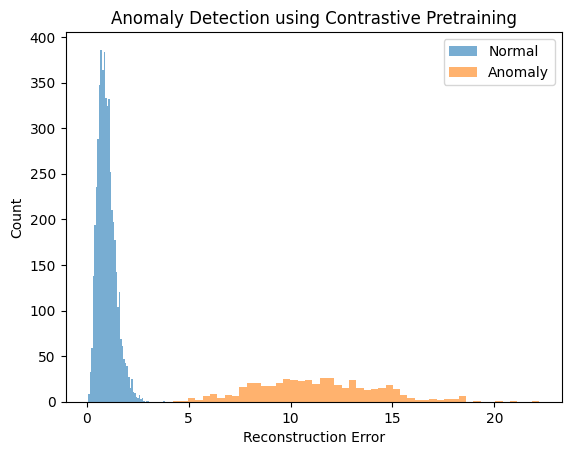

In [15]:
plt.hist(err_norm.cpu(), bins=50, alpha=0.6, label="Normal")
plt.hist(err_anom.cpu(), bins=50, alpha=0.6, label="Anomaly")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.title("Anomaly Detection using Contrastive Pretraining")
plt.show()
